## word2vec의 CBOW 모델
Chapter2에서는 단어를 벡터로 표현할 때, 통계 기반 기법을 사용했다.
이번에는 word2vec의 CBOW 모델을 사용하여 추론 기반 기법을 사용하여 단어를
벡터로 표현해 보겠다. 

통계 기반 기법은 어휘가 많아질 수록, 계산량이 많아져 적용하기 힘들어진다. 예를 들어, 100만 어휘로 이루어진 corpus를 사용한다고 하면, 마지막 SVD 처리 과정에서 계산량이 너무 많아져 과부하가 걸릴 것이다. (SVD는 대량의 계산량을 한번에 처리하며, 보통 O(n^3)의 시간복잡도를 가진다.)

추론 기반 기법 같은 경우, 통계 기반 기법과는 달리, 대량의 corpus를 작은 미니배치로 나누어서 연산을 하기 때문에, 대량의 데이터를 연산할 수 있다. 또한, GPU를 통한 병렬 계산을 이요하면 더욱 계산 속도를 향상시킬 수 있다.

In [ ]:
# 전처리
def preprocess(text):
  text = text.lower()
  text = text.replace('.', ' .')
  words = text.split(' ')

  word_to_id = {}
  id_to_word = {}

  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word

  corpus = np.array([word_to_id[x] for x in words])
  return corpus, word_to_id, id_to_word

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

# 입력과 target을 만든다.
def create_contexts_target(corpus, window_size=1):
  target = corpus[window_size:-window_size]
  contexts = []

  for idx in range(window_size, len(corpus)-window_size):
    cs = []
    for t in range(-window_size, window_size+1):
      if t == 0:
        continue
      cs.append(corpus[idx+t])
    contexts.append(cs)
  
  return np.array(contexts), np.array(target)

contexts, target = create_contexts_target(corpus)

print(contexts)
print(target)

[0 1 2 3 4 1 5 6]
[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

vocab_size = len(word_to_id)

# 원 핫 벡터로 만든다.
target = to_categorical(target, 7) 
contexts = to_categorical(contexts)

print(target)
print(contexts)

[[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]
[[[1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0.]]

 [[0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0.]]

 [[0. 0. 0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0.]]

 [[0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1.]]]


### CBOW 모델 코딩
다음 코드는 CBOW 모델을 구현한 것이다.
은닉층의 뉴런 수를 출력층의 뉴런 수 보다 적게 하는 것이 중요한 핵심인데, 이렇게 해야 은닉층에는 단어 예측에 필요한 정보를 간결하게 담게 되며, 결과적으로 밀집젝터를 얻을 수 있다. 

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.93
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.93
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.92
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.92
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.92
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.91
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.91
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.91
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.90
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.91
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.89
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.90
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.89
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.89
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.89
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.88
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.88
| 에폭 26 |

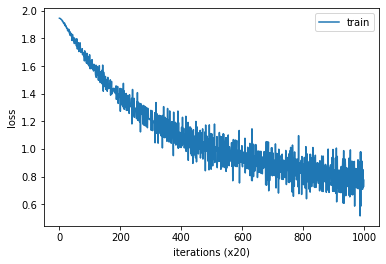

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

def cross_entropy_error(x, t, eps=1e-8):
  return -np.sum(t * np.log(x + eps)) / x.shape[0]

def softmax(x):
  c = np.max(x, axis=1)
  exp = np.exp(x.T - c).T
  exp_sum = np.sum(exp, axis=1)
  return (exp.T / exp_sum).T

# 소프트맥스 함수와, 손실함수가 합쳐진 층
class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss
  
  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    return (self.y - self.t) / batch_size

# 행렬 곱 layer
class MatMul:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.x = None

  def forward(self, x):
    W, = self.params
    self.x = x
    out = np.matmul(x, W)
    return out

  def backward(self, dout):
    W, = self.params
    dx = np.matmul(dout, W.T)
    dW = np.matmul(self.x.T, dout)
    self.grads[0][...] = dW
    return dx

# 중복된 가중치 제거
def remove_duplicate(params, grads):
  '''
  매개변수 배열 중 중복되는 가중치를 하나로 모아
  그 가중치에 대응하는 기울기를 더한다.
   '''
  params, grads = params[:], grads[:]  # copy list

  while True:
    find_flg = False
    L = len(params)

    for i in range(0, L - 1):
      for j in range(i + 1, L):
        # 가중치 공유 시
        if params[i] is params[j]:
          grads[i] += grads[j]  # 경사를 더함
          find_flg = True
          params.pop(j)
          grads.pop(j)
        # 가중치를 전치행렬로 공유하는 경우(weight tying)
        elif params[i].ndim == 2 and params[j].ndim == 2 and \
          params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
          grads[i] += grads[j].T
          find_flg = True
          params.pop(j)
          grads.pop(j)

        if find_flg: break
      if find_flg: break

    if not find_flg: break

  return params, grads

# trainer (fit, 배치 생성, plot 역할을 한다.)
class Trainer:
  def __init__(self, model, optimizer):
    self.model = model
    self.optimizer = optimizer
    self.loss_list = []
    self.eval_interval = None
    self.current_epoch = 0

  def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
    data_size = len(x)
    max_iters = data_size // batch_size
    self.eval_interval = eval_interval
    model, optimizer = self.model, self.optimizer
    total_loss = 0
    loss_count = 0

    start_time = time.time()
    for epoch in range(max_epoch):
      # 뒤섞기
      idx = np.random.permutation(np.arange(data_size))
      x = x[idx]
      t = t[idx]

      for iters in range(max_iters):
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]

        # 기울기 구해 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
        """
        if max_grad is not None:
          clip_grads(grads, max_grad)
        """
        optimizer.update(params, grads)
        total_loss += loss
        loss_count += 1

        # 평가
        if (eval_interval is not None) and (iters % eval_interval) == 0:
          avg_loss = total_loss / loss_count
          elapsed_time = time.time() - start_time
          print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
            % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
          self.loss_list.append(float(avg_loss))
          total_loss, loss_count = 0, 0

      self.current_epoch += 1

  def plot(self, ylim=None):
    x = np.arange(len(self.loss_list))
    if ylim is not None:
      plt.ylim(*ylim)
    plt.plot(x, self.loss_list, label='train')
    plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

# optimizer
class AdaGrad:
  def __init__(self, lr=0.01):
    self.lr = lr
    self.h = None

  def update(self, params, grads):
    if self.h is None:
      self.h = []
      for param in params:
        self.h += [np.zeros_like(param)]

    for idx, param in enumerate(params):
      self.h[idx] += grads[idx] * grads[idx]
      param -= self.lr * grads[idx] / (np.sqrt(self.h[idx]) + 1e-8)

class SimpleCBOW:
  def __init__(self, vocab_size, hidden_size):
    V, H = vocab_size, hidden_size

    W_in = 0.01 * np.random.randn(V, H).astype('f')
    W_out = 0.01 * np.random.randn(H, V).astype('f')

    self.in_layer0 = MatMul(W_in)
    self.in_layer1 = MatMul(W_in)
    self.out_layer = MatMul(W_out)
    self.loss_layer = SoftmaxWithLoss()

    layers = [self.in_layer0, self.in_layer1, self.out_layer]
    self.params, self.grads = [], []

    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads

    self.word_vecs = W_in

  def forward(self, contexts, target):
    h0 = self.in_layer0.forward(contexts[:, 0])
    h1 = self.in_layer1.forward(contexts[:, 1])
    h = (h0 + h1) * 0.5
    score = self.out_layer.forward(h)
    loss = self.loss_layer.forward(score, target)
    return loss

  def backward(self, dout=1):
    ds = self.loss_layer.backward(dout)
    da = self.out_layer.backward(ds)
    da *= 0.5
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    return None

max_epoch = 1000
batch_size = 3
hidden_size = 5

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = AdaGrad()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

### word_vecs 확인하기
CBOW 모델로 표현한 단어들의 밀집 벡터를 확인해 보자.

In [ ]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
  print(word, word_vecs[word_id])

you [ 0.7075533  -0.6814518   0.6890196  -0.66104513 -0.67227894]
say [ 0.03140384 -0.0913246  -0.9230519   0.94439375  0.2098045 ]
goodbye [ 0.5516965 -0.6881148  0.7442056 -0.74489   -0.6990536]
and [ 0.8682097  -0.8857231  -0.8456772   0.84009355 -0.8511206 ]
i [ 0.5806212  -0.67244124  0.77986974 -0.7222685  -0.6905044 ]
hello [ 0.6951594  -0.6885862   0.68979424 -0.6623594  -0.6889648 ]
. [-0.8076689   0.8157925  -0.7282155   0.72858685  0.7937453 ]
